In [1]:
'''
Importing Libraries
'''
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import time
import json
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import SmoothingFunction
smoothing_fn = SmoothingFunction().method4
print(torch.__version__)

1.6.0


In [2]:
from torchtext.data import Field, BucketIterator

In [3]:
import pickle

In [4]:
'''
Import Data from Pickle 
'''
with open('./en_hi_data/en_hi.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.head())

                              english                           hindi
57382              Who is this man?\n             -ये आदमी कौन है ?\n
28149        And the other brother?\n                 और दूसरे भाई?\n
80284  - Greetings, Mustakeen bhai.\n        नमस्ते, Mustakeen भाई।\n
63596     Please, reason with them.\n  कृपया, उन लोगों के साथ कारण.\n
9459        There's a howling gale.\n             तेज़ हवा आ रही है।\n


In [5]:
dataset = {'en' : [], 'hi' : [] }
for k in data['english'].keys():
    dataset['en'].append(data['english'][k]) 
    dataset['hi'].append(data['hindi'][k])


In [6]:
'''
Creating Train Dev and Test Datasets
'''
X_train, X_test, y_train, y_test = train_test_split(data['english'] , data['hindi'], test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_test , y_test, test_size=0.2, random_state=42)

In [7]:
'''
Merging into Dataframes
'''
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
dev_data = pd.concat([X_dev, y_dev], axis=1)

In [8]:
'''
Creating CSV files for Training, Dev and Test Datasets
'''

# with open("train_data.csv", "w") as outfile:  
#     train_data.to_csv(outfile, sep=',', encoding='utf-8') 
# with open("test_data.csv", "w") as outfile:  
#     test_data.to_csv(outfile, sep=',', encoding='utf-8') 
# with open("dev_data.csv", "w") as outfile:  
#     dev_data.to_csv(outfile, sep=',', encoding='utf-8')  

'\nCreating CSV files for Training, Dev and Test Datasets\n'

In [9]:
import unicodedata
def unicode_to_ascii(s):
    return ''.join( c for c in unicodedata.normalize( 'NFD', s ) if unicodedata.category( c ) != 'Mn' )

'''
Tokenization for English
'''
def add_spaces_eng(w):
#     print(w)
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)    
    w = w.lower()
    w = re.sub(r"[^a-z?.!,]+", " ", w)    
    w = w.strip()
#     print(w)
    arr = unicode_to_ascii(w)
#     print(arr)
    return arr.split()

'''
Tokenization for Hindi
'''
def add_spaces_hin(w):
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()
    arr = unicode_to_ascii(w)
#     print(arr)
    return arr.split()

In [10]:
'''
Creating Torchtext Fields
'''
english = Field(tokenize = add_spaces_eng,lower = True,init_token = "<s>",eos_token = "<e>")
hindi = Field(tokenize = add_spaces_hin,lower = True,init_token = "<s>",eos_token = "<e>")

/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
'''
Creating dataset tensors for training 
'''
from torchtext.data import TabularDataset, Field 
train_data, valid_data, test_data = TabularDataset.splits( path="./", train="train_data.csv", 
                                                          validation="dev_data.csv",
                                                          test="test_data.csv",  format="CSV",
                                                          fields= [("english", english), ("hindi", hindi)])

/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/home/tanvi/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [12]:
'''
Creating Vocab
'''
english.build_vocab(train_data.english,max_size = 10000,min_freq = 3)
hindi.build_vocab(train_data.hindi,max_size = 10000,min_freq = 2)


In [13]:
'''
Defining Encoder
'''
class Encoder(nn.Module):
    
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout)

    def forward(self, x):
        embedding = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedding)
        return hidden, cell

In [14]:
'''
Defining Decoder 
'''
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)
        embedding = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        predictions = self.fc(outputs.squeeze(0))
        return predictions, hidden, cell

In [15]:
'''
Creating the Model
'''
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.decoder.output_size
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)
        x = target[0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_force_ratio
            best_guess = output.argmax(1)
            x = target[t] if random.random() < teacher_force else best_guess
        return outputs

In [36]:
'''
Important Parmeters
'''
num_epochs = 8
learning_rate = 0.1
batch_size = 128

In [37]:
'''
HyperParameters
'''
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(english.vocab)
input_size_decoder = len(hindi.vocab)
output_size = len(hindi.vocab)
encoder_embedding_size = 256
decoder_embedding_size = 256
hidden_size = 512
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

In [38]:
'''
BucketIterator
'''
train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = batch_size, 
    device = device, sort = False, 
    sort_within_batch = True, 
    sort_key = lambda x:len(x.hindi),
     )

In [39]:
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size,num_layers, enc_dropout)
decoder_net = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout)

In [40]:
'''
Initiating Model
'''
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_( param.data, -0.08, 0.08 )
model = Seq2Seq(encoder_net, decoder_net).to(device)
model.apply( init_weights )
'''
Using Adam Optimizer
'''
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
pad_idx = english.vocab.stoi[english.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)

In [42]:
'''
Train Function (For Training set )
'''
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate( iterator ):
        src = batch.english
        trg = batch.hindi
        optimizer.zero_grad()
        output = model( src, trg )
        output_dim = output.shape[-1]
        output = output[1:].view( -1, output_dim )
        trg = trg[1:].view( -1 )
        loss = criterion( output, trg )
        loss.backward()
        torch.nn.utils.clip_grad_norm_( model.parameters(), clip )
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len( iterator )

In [46]:
'''
Evaluate function to test the model of Validation Set 
'''

def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate( iterator ):
            src = batch.english
            trg = batch.hindi

            output = model( src, trg, 0 )  # turn off teacher forcing

            output_dim = output.shape[-1]

            output = output[1:].view( -1, output_dim )
            trg = trg[1:].view( -1 )

            loss = criterion( output, trg )

            epoch_loss += loss.item()

    return epoch_loss / len( iterator )

In [47]:
'''
Calculating the bleu score
'''
from torchtext.data.metrics import bleu_score
def bleu(data, model, hindi, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["english"]
        trg = vars(example)["hindi"]

        prediction = translate_sentence(model, src, english, hindi, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


'''
For the checkpoints
'''
def save_checkpoint(state, filename="my_checkpoint_seq2Seq.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [48]:
'''
Training the model
'''
import math

tr_loss = []
val_loss = []
for epoch in range(num_epochs):
    
    train_loss = train( model, train_iterator, optimizer, criterion, 1 )
    tr_loss.append(train_loss)
    valid_loss = evaluate( model, validation_iterator, criterion)
    val_loss.append(valid_loss)
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)
    
    print( 'Epoch:', epoch + 1 )
    print( 'Train Loss:', round(train_loss,2) )
    print( 'Val. Loss:', round(valid_loss,2) )


=> Saving checkpoint
Epoch: 1
Train Loss: 9.62
Val. Loss: 8.25
=> Saving checkpoint
Epoch: 2
Train Loss: 8.71
Val. Loss: 7.5
=> Saving checkpoint
Epoch: 3
Train Loss: 8.16
Val. Loss: 7.07
=> Saving checkpoint
Epoch: 4
Train Loss: 7.84
Val. Loss: 6.72
=> Saving checkpoint
Epoch: 5
Train Loss: 7.22
Val. Loss: 8.5
=> Saving checkpoint
Epoch: 6
Train Loss: 7.26
Val. Loss: 6.67
=> Saving checkpoint
Epoch: 7
Train Loss: 6.87
Val. Loss: 6.65
=> Saving checkpoint
Epoch: 8
Train Loss: 6.86
Val. Loss: 6.21


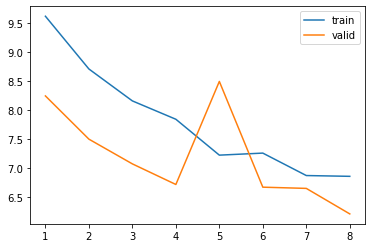

In [50]:
'''
Plotting the graphs
'''
x=[i for i in range(1,9)]
# train_loss=[6.660, 6.180, 6.092, 6.164, 5.847, 5.262, 4.952, 4.880]
# val_loss = [5.709, 5.571, 5.790, 5.437, 5.795, 4.856, 4.696, 4.620]
plt.plot(x,tr_loss,label='train')
plt.plot(x,val_loss,label='valid')
plt.legend() 
plt.show()

In [ ]:
'''
Translating Sentences
'''
def translate_sentence(model, sentence, english, hindi, device, max_length=20):
    
    if type(sentence) == str:
        tokens = add_spaces_eng(sentence)
    else:
        tokens = [token.lower() for token in sentence]

#     print(tokens)

    tokens.insert(0, english.init_token)
    tokens.append(english.eos_token)
    text_to_indices = [english.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)
    with torch.no_grad():
        hidden, cell = model.encoder(sentence_tensor)

    outputs = [hindi.vocab.stoi["<s>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()
        outputs.append(best_guess)
        if output.argmax(1).item() == hindi.vocab.stoi["<e>"]:
            break
    translated_sentence = [hindi.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]


In [ ]:
'''
Testing the model
'''
num = 1
for i in test_data:
    print(f'Example #{num}' )
    num+=1
    print('English Input:' ,' '.join(i.english))
    print('Expected Output:',' '.join(i.hindi))
    print('Actual Output:',' '.join(translate_sentence(model, ' '.join(i.english), english, hindi, device)))
    print()